In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flavio
import weight_calulations as wc
from tqdm import tqdm
import pickle

from functools import lru_cache

# Train on the weighted grid

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Read pickle data

In [98]:
current_file = 'grids_1_12_20_fixed.pkl'
pickle_file = open('data/' + current_file, 'rb')
grid_1 = pickle.load(pickle_file)
pickle_file.close()

grid_1_2d = [g.sum(axis=1) for g in grid_1]

current_file = 'coefficients_1_12_20_fixed.pkl'
pickle_file = open('data/' + current_file, 'rb')
coef_1 = pickle.load(pickle_file)
pickle_file.close()

## Plot pickle data

In [99]:
points_per_axis = 16
number_of_features = 3
grid = np.ones([points_per_axis] * number_of_features)

q_range = np.linspace(0.5,2, points_per_axis)
l_range = np.linspace(0,np.pi, points_per_axis)
k_range = np.linspace(0,np.pi, points_per_axis)
p_range = np.linspace(-np.pi,np.pi, points_per_axis)

x, y, z = np.meshgrid(q_range, k_range, l_range)

{'c9': 0, 'c10': 0.31914920019049964}


ValueError: s must be a scalar, or float array-like with the same size as x and y

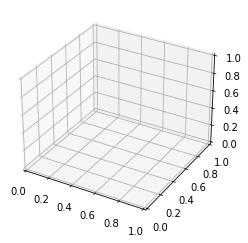

In [100]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
n = 5
ex_grid = grid_1[n]
print(coef_1[n])

ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 7e-1, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')

plt.show()
plt.imshow(ex_grid.sum(axis=1))

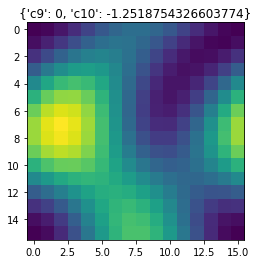

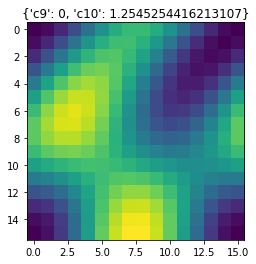

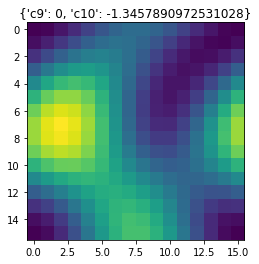

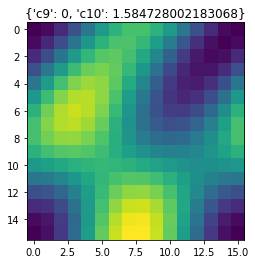

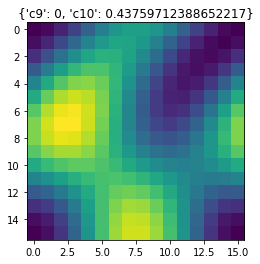

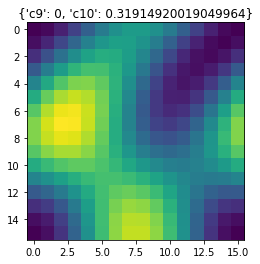

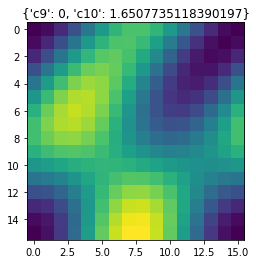

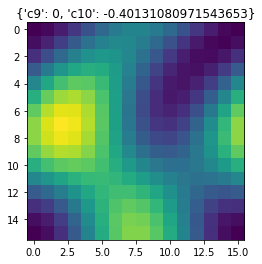

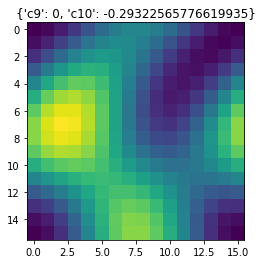

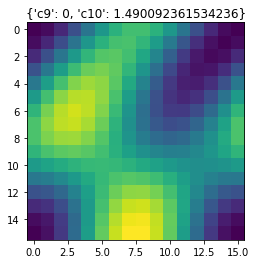

In [127]:
for i in range(10):
    plt.title(coef_1[i])
    plt.imshow(grid_1[i])
    plt.show()

# Modelling

## 2D CNN

In [111]:
X_2d = np.array(grid_1).reshape(len(grid_1),16,16,1)
# X_2d = np.array(grid_1_2d).reshape(len(grid_1_2d),16,16,1)
Y = np.array([list(c.values()) for c in coef_1])
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, Y)

In [112]:
# scale the data
# ss_2d = StandardScaler().fit(X_train_2d)
# X_train_2d = X_train_2d.transform()
X_train_2d_scaled = np.array([xx/xx.max() for xx in X_train_2d])
X_test_2d_scaled = np.array([xx/xx.max() for xx in X_test_2d])

[ 0.         -1.78080049]


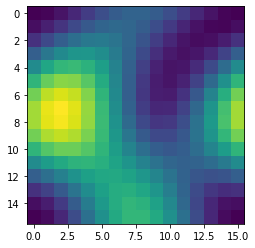

In [113]:
n = 7
print(y_train_2d[n])
plt.imshow(X_train_2d_scaled[n].reshape(16,16))

In [114]:
n = 100
l1 = 30
l2 = 2
out = 2
model_tf_2d = keras.Sequential()
model_tf_2d.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(16,16,1)))
model_tf_2d.add(layers.MaxPool2D((2,2)))
model_tf_2d.add(layers.Conv2D(32,(3,3), activation='relu'))
model_tf_2d.add(layers.Dense(l1, activation='relu'))  # first layer takes in n inputs and outputs to l1 nodes
model_tf_2d.add(layers.Flatten())
model_tf_2d.add(layers.Dense(out, activation='linear'))    # last layer takes in l1 nodes and outputs to out nodes

In [115]:
model_tf_2d.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [116]:
model_tf_2d.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          4640      
_________________________________________________________________
dense_54 (Dense)             (None, 5, 5, 30)          990       
_________________________________________________________________
flatten_2 (Flatten)          (None, 750)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 1502      
Total params: 7,292
Trainable params: 7,292
Non-trainable params: 0
___________________________________________________

In [118]:
history = model_tf_2d.fit(
    X_train_2d_scaled, 
    y_train_2d,
    batch_size=1000,
    epochs=10,
    # validation_data=(x_test, y_test)
)


Epoch 1/10
8/8 [==============================] - 1s 30ms/step - loss: 0.6567 - mean_squared_error: 0.6567
Epoch 2/10
8/8 [==============================] - 0s 29ms/step - loss: 0.6083 - mean_squared_error: 0.6083
Epoch 3/10
8/8 [==============================] - 0s 29ms/step - loss: 0.5453 - mean_squared_error: 0.5453
Epoch 4/10
8/8 [==============================] - 0s 28ms/step - loss: 0.4393 - mean_squared_error: 0.4393
Epoch 5/10
8/8 [==============================] - 0s 31ms/step - loss: 0.2785 - mean_squared_error: 0.2785
Epoch 6/10
8/8 [==============================] - 0s 28ms/step - loss: 0.0934 - mean_squared_error: 0.0934
Epoch 7/10
8/8 [==============================] - 0s 44ms/step - loss: 0.0148 - mean_squared_error: 0.0148
Epoch 8/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 9/10
8/8 [==============================] - 0s 37ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 10/10
8/8 [====================

In [119]:
pred = model_tf_2d.predict(X_test_2d_scaled)

print(f'R^2    - {r2_score(pred, y_test_2d)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test_2d[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test_2d[:,1])}')

R^2    - 0.4828858433184262
R^2(a) - -0.025477609521671996
R^2(b) - 0.9912492713400336


# Flat Model

In [94]:
model_flat = keras.Sequential()
# model_flat.add(layers.Flatten())
model_flat.add(layers.Dense(100, activation='relu'))
model_flat.add(layers.Dense(1, activation='linear'))

model_flat.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [95]:
flat_history = model_flat.fit(
    flattened_x_train, 
    y_train_2d, 
    epochs=10,
    batch_size=10
)

pred = model_flat.predict(flattened_x_test)
print(f'R^2    - {r2_score(pred, y_test_2d)}')

Epoch 1/10
750/750 [==============================] - 5s 1ms/step - loss: 0.0525 - mean_squared_error: 0.0525
Epoch 2/10
750/750 [==============================] - 1s 965us/step - loss: 7.1067e-04 - mean_squared_error: 7.1067e-04
Epoch 3/10
750/750 [==============================] - 1s 787us/step - loss: 5.7833e-04 - mean_squared_error: 5.7833e-04
Epoch 4/10
750/750 [==============================] - 1s 836us/step - loss: 6.0035e-04 - mean_squared_error: 6.0035e-04
Epoch 5/10
750/750 [==============================] - 1s 846us/step - loss: 6.0323e-04 - mean_squared_error: 6.0323e-04
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 5.7346e-04 - mean_squared_error: 5.7346e-04
Epoch 8/10
750/750 [==============================] - 1s 974us/step - loss: 5.8440e-04 - mean_squared_error: 5.8440e-04
Epoch 9/10
750/750 [==============================] - 1s 954us

In [92]:
xxx, yyy = np.random.uniform(0,1,10_000), np.random.uniform(0,1,10_000)
zzz = xxx * yyy

xxx_yyy = np.vstack([xxx, yyy]).T

blabla = keras.Sequential()
# model_flat.add(layers.Flatten())
blabla.add(layers.Dense(100, activation='relu'))
# blabla.add(layers.Dense(100, activation='relu'))
blabla.add(layers.Dense(1, activation='relu'))

blabla.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

flat_history = blabla.fit(
    xxx_yyy, 
    zzz, 
    batch_size=1000,
    epochs=10,
)

mlp_blabla = MLPRegressor(max_iter=1000)
mlp_blabla.fit(xxx_yyy, zzz)

Epoch 1/10
10/10 [==============================] - 0s 988us/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 4/10
10/10 [==============================] - 0s 1ms/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 8/10
10/10 [==============================] - 0s 961us/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.1110 - mean_squared_error: 0.1110
Epoch 10/10
10/10 [=====

MLPRegressor(max_iter=1000)

In [87]:
blabla.predict([[.2,.4]]), mlp_blabla.predict([[.2,.4]])

(array([[0.]], dtype=float32), array([0.08057498]))

In [45]:
flattened_x_train = X_train_2d_scaled.reshape(7500, 16**2)
flattened_x_test = X_test_2d_scaled.reshape(2500, 16**2)

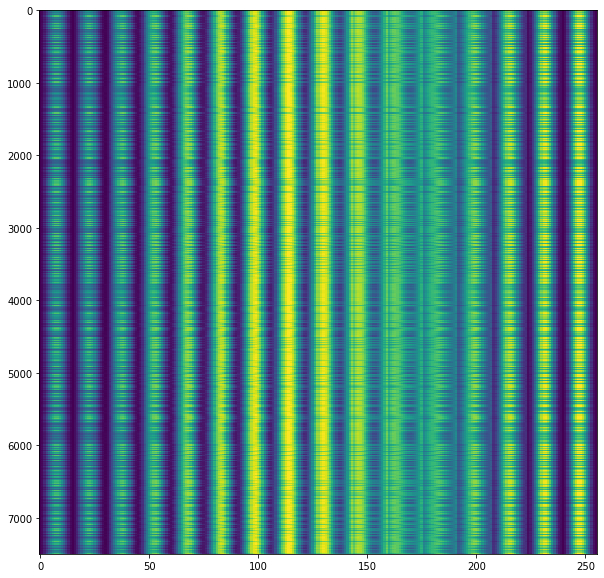

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(flattened_x_train[:], aspect='auto', interpolation='nearest')

In [13]:
df = pd.DataFrame(flattened_x_test)
df['y'] = y_test_2d

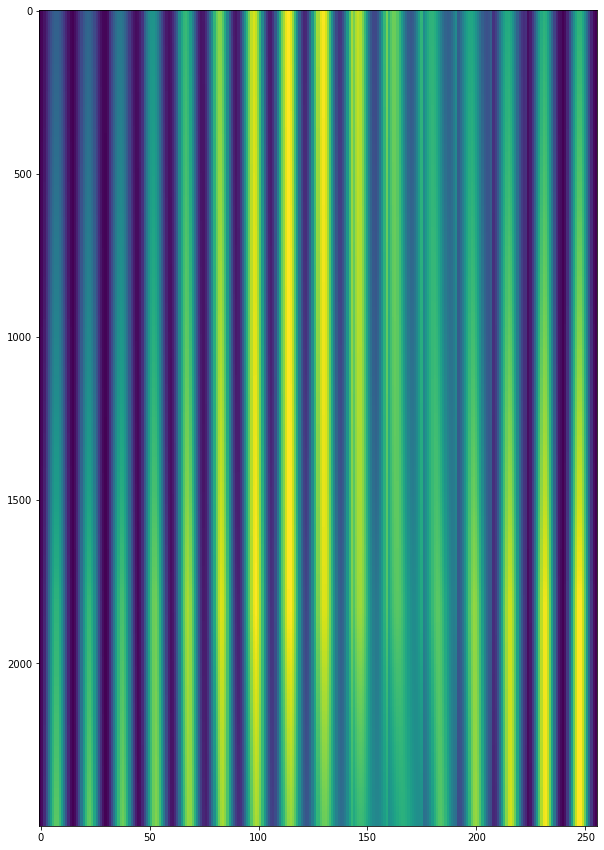

In [14]:
plt.figure(figsize=(10,15))
plt.imshow(df.sort_values('y').iloc[:,:-1], aspect='auto', interpolation='nearest')

In [15]:
mlp_flat = MLPRegressor()
mlp_flat.fit(flattened_x_train, y_train_2d)
mlp_flat.score(flattened_x_test, y_test_2d)

0.9996147128916772

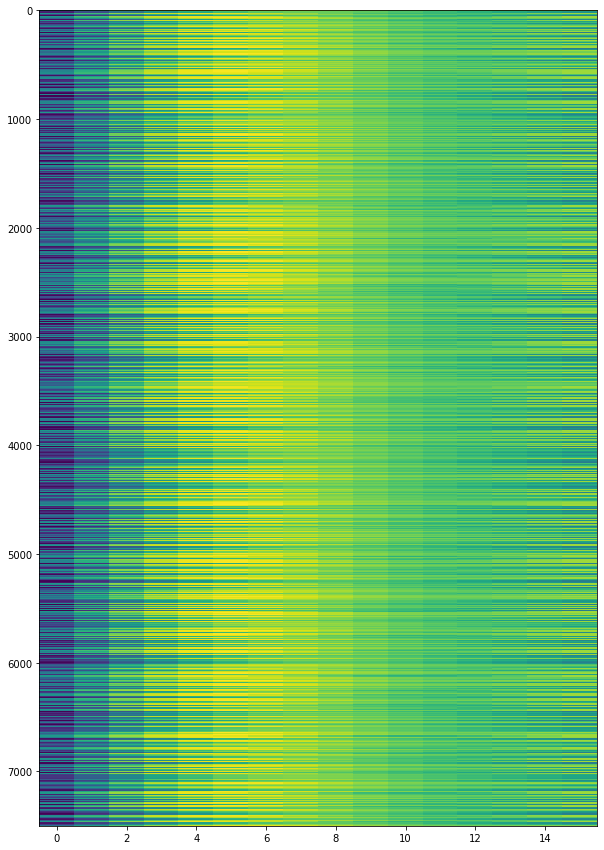

In [16]:
plt.figure(figsize=(10,15))
plt.imshow(flattened_x_train[:,5::16], aspect='auto', interpolation='nearest')